In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import pandas as pd
df = pd.read_csv('../data/amazon_subset_0512.csv', index_col=0)
df = df[['title_x', 'asin', 'images_x']]
df = df[df['images_x'] != '[]']
print(len(df))

1008


In [3]:
# get main image url for each product
import json
urls = []
for images in df["images_x"]:
    images = images.replace("'", "\"")
    images = images.replace("None", "null")
    images = json.loads(images)
    urls.append(images[0]['large'])
df['main_image_url'] = urls

In [4]:
# Download images in PIL format
import numpy as np
import urllib.request
import cv2
from PIL import Image
from tqdm.auto import tqdm

images = [] # in memory for now, might need to save to disk for scaling
for url in tqdm(urls):
    # Open the URL and read the image
    try:
        resp = urllib.request.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")

        # Decode the image
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)

        # Convert image to RGB (PIL format) from BGR (OpenCV format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(Image.fromarray(image))
    except Exception as e:
        print(url)
        print(e)

  0%|          | 0/1008 [00:00<?, ?it/s]

In [5]:
# load CLIP embedding model
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import torch

torch.set_num_threads(4)
# small model
model = SentenceTransformer('clip-ViT-B-32')
# # large model
# model = SentenceTransformer('clip-ViT-L-14')

In [6]:
torch.__version__

'2.3.0+cu121'

In [7]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [8]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Ti'

In [10]:
# Compute all image embeddings
img_emb = model.encode(images, batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
emb_shape = img_emb[0].shape
print(f'Embedding shape: {emb_shape}')

Embedding shape: torch.Size([512])


In [12]:
# initialize Pinecone vector store
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()

# create vector store
index_name = 'product-images-test'
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=emb_shape[0],
        metric='cosine',
        spec=ServerlessSpec(
            cloud='aws', 
            region='us-east-1'
        )
    )

In [13]:
vector_store = pc.Index(index_name)
vector_store.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [15]:
# add indexed embeddings to vector store
from uuid import uuid4

# format records: id, values, metadata
image_ids = []
records = []

for i, emb in enumerate(img_emb):
    id = str(uuid4())
    image_ids.append(id)
    records.append({
        "id": id,
        "values": emb,
        "metadata": {# add asin/name later
            "url": df.iloc[i]['main_image_url']
        }
    })
# save id for retrieval

    
# Pinecone only allows 1000 vectors per request
batch_limit = 1000
for i in range(len(records) // batch_limit + 1):
    batch = records[i*batch_limit: min(len(records), (i+1)*batch_limit)]
    vector_store.upsert(
        vectors=batch
    )

In [26]:
vector_store.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1008}},
 'total_vector_count': 1008}

In [24]:
def search(query, k=3):
    query_emb = model.encode(
        [query],
        convert_to_tensor=False,
        show_progress_bar=False
    ).tolist()
    results = vector_store.query(
        vector=query_emb,
        top_k=k,
        include_values=False
    )
    return results

In [27]:
res = search("jacket")
print(res)

{'matches': [{'id': '0f504983-2eb7-4f2d-a87e-ac7a78b0bbcd',
              'score': 0.28422606,
              'values': []},
             {'id': '8738dea7-890f-475b-9bc6-8f5a0734fe9f',
              'score': 0.281974941,
              'values': []},
             {'id': '6ea3aa1e-fd6a-4444-958e-06f2716c8092',
              'score': 0.280302316,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 5}}


In [60]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    # Decode the image
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Convert image to RGB (PIL format) from BGR (OpenCV format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(image)

https://m.media-amazon.com/images/I/41WVKwoitvL._AC_.jpg


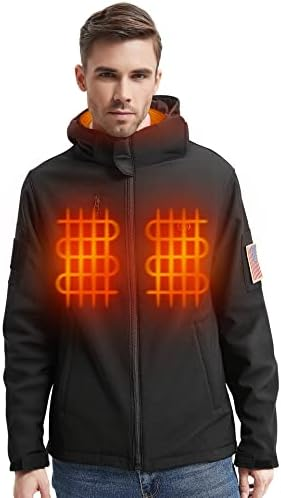

https://m.media-amazon.com/images/I/41NlD0tJcaL._AC_.jpg


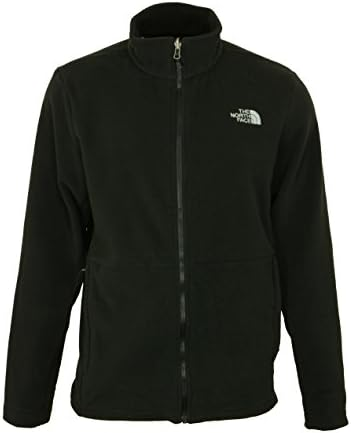

https://m.media-amazon.com/images/I/310Hhbgd31L._AC_.jpg


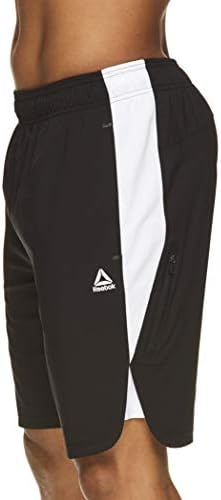

In [61]:
from IPython.display import display
full_res = vector_store.fetch([match['id'] for match in res['matches']])
for match in full_res['vectors'].values():
    print(match['metadata']['url'])
    image = url_to_image(match['metadata']['url'])
    display(image)

!! THESE ARE BAD RESULTS !!

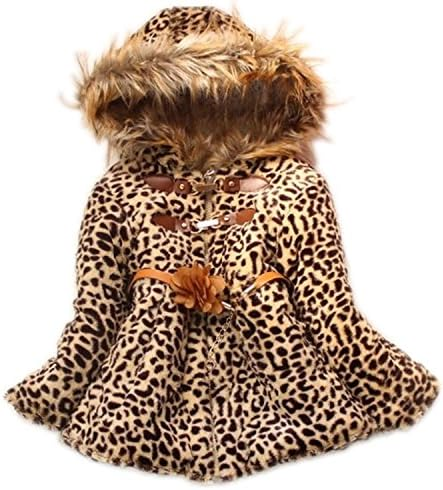

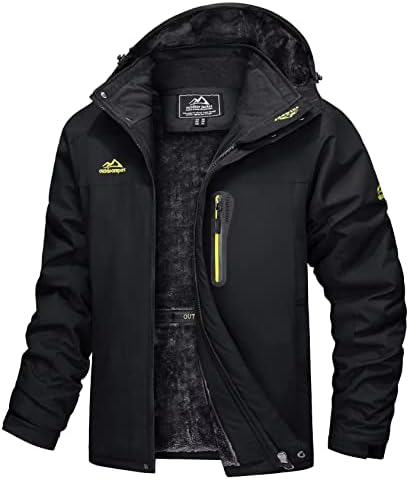

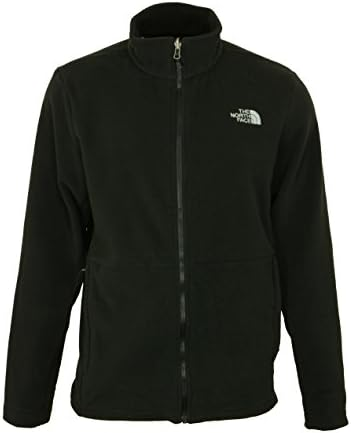

In [62]:
# compare with raw string search (actually better)
jackets = df[df['title_x'].str.contains('jacket', case=False)]
for url in jackets.head(3)['main_image_url']:
    image = url_to_image(url)
    display(image)